# Imports

In [1]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import json
pd.options.display.max_columns = 9999999

In [3]:
data = []

with gzip.open('ucimessages_5_injected_H15000.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
len(data)

62784

In [5]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 1082008561, 'u': '1', 'v': '2', 'is_fraud': 0, 'history_type': 'H', 'history_size': 15000, 'bip': False, 'cost': 0.0}
{'t': 1082008561, 'u': '1352', 'v': '1685', 'is_fraud': 1, 'history_type': 'H', 'history_size': 15000, 'bip': False, 'cost': 0.0}
{'t': 1082123439, 'u': '3', 'v': '4', 'is_fraud': 0, 'history_type': 'H', 'history_size': 15000, 'bip': False, 'cost': 0.0}
{'t': 1082381991, 'u': '2', 'v': '5', 'is_fraud': 0, 'history_type': 'H', 'history_size': 15000, 'bip': False, 'cost': 0.0}
{'t': 1082407219, 'u': '6', 'v': '7', 'is_fraud': 0, 'history_type': 'H', 'history_size': 15000, 'bip': False, 'cost': 0.0}


# Flatten the internal `O(1)` features

In [6]:
from utilitiesMe import flatten_dict

In [7]:
# Flattening all rows(
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [8]:
data_flattened[0]

{'t': 1082008561,
 'u': '1',
 'v': '2',
 'is_fraud': 0,
 'history_type': 'H',
 'history_size': 15000,
 'bip': False,
 'cost': 0.0}

# Convert flattened json to dataframe

In [9]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [10]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,5.0,26.0,73.0,2.0,363.0,36.0,5.0,26.0,69.0,4.0,577.0,244.0,4054.0,15000.0,2021.0,648.0,1.0,184.0,2.0,1.0,2021.0,2033.0
62780,1098744436,1097,1899,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,7.0,27.0,34.0,3.0,277.0,34.0,11.0,27.0,30.0,5.0,391.0,240.0,4055.0,15000.0,2022.0,649.0,1.0,184.0,2.0,1.0,2022.0,2033.0
62781,1098744603,1899,277,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,15.0,28.0,10.0,3.0,110.0,32.0,39.0,28.0,2.0,7.0,185.0,234.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,1.0,2023.0,2033.0
62782,1098744711,1624,1878,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1180.0,3.0,10.0,87.0,29.0,1.0,185.0,4.0,30.0,1180.0,7.0,1.0,224.0,0.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,11.0,37.0,232.0


In [11]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,5.0,26.0,73.0,2.0,363.0,36.0,5.0,26.0,69.0,4.0,577.0,244.0,4054.0,15000.0,2021.0,648.0,1.0,184.0,2.0,1.0,2021.0,2033.0
62780,1098744436,1097,1899,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,7.0,27.0,34.0,3.0,277.0,34.0,11.0,27.0,30.0,5.0,391.0,240.0,4055.0,15000.0,2022.0,649.0,1.0,184.0,2.0,1.0,2022.0,2033.0
62781,1098744603,1899,277,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,15.0,28.0,10.0,3.0,110.0,32.0,39.0,28.0,2.0,7.0,185.0,234.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,1.0,2023.0,2033.0
62782,1098744711,1624,1878,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1180.0,3.0,10.0,87.0,29.0,1.0,185.0,4.0,30.0,1180.0,7.0,1.0,224.0,0.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,11.0,37.0,232.0


In [12]:
df.describe()

,timestamp,is_fraud,history_size,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,6.278400e+04,62784.000000,62784.0,6.278400e+04,47784.000000,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000
mean,1.086024e+09,0.047608,15000.0,9.954766e-07,1494.251883,441.783589,277.980391,1.0,151.471246,2.646681,405.426963,224.118387,1.0,599.832413,3.559162,11.846748,36.150615,74.968044,16.349238,328.669534,101.300624,56.583480,164.362485,34.910828,7.750628,309.243471,113.063243,4639.551858,15000.0,2303.861041,825.274506,1.0,117.661100,1.747991,9.100703,822.867068,1108.388770
std,3.186740e+06,0.212936,0.0,1.247140e-04,64.639487,24.023527,20.508428,0.0,32.450043,0.478006,25.934629,11.627492,0.0,172.349378,0.762821,10.085100,29.087595,106.141845,40.931488,259.314415,143.097134,69.525094,158.047639,81.813399,31.327399,265.083005,160.519371,187.061247,0.0,109.324224,80.312739,0.0,25.892752,0.434171,16.541569,938.356725,874.991392
min,1.082009e+09,0.000000,15000.0,0.000000e+00,1383.000000,381.000000,241.000000,1.0,86.000000,2.000000,341.000000,191.000000,1.0,360.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4035.000000,15000.0,2001.000000,640.000000,1.0,70.000000,1.000000,1.000000,1.000000,0.000000
25%,1.083976e+09,0.000000,15000.0,0.000000e+00,1442.000000,426.000000,265.000000,1.0,133.000000,2.000000,386.000000,218.000000,1.0,470.000000,3.000000,5.000000,16.000000,13.000000,2.000000,131.000000,15.000000,11.000000,56.000000,2.000000,1.000000,102.000000,15.000000,4526.000000,15000.0,2230.000000,760.000000,1.0,95.000000,1.000000,1.000000,51.000000,285.000000
50%,1.085087e+09,0.000000,15000.0,0.000000e+00,1484.000000,445.000000,273.000000,1.0,146.000000,3.000000,411.000000,224.000000,1.0,541.000000,3.000000,9.000000,27.000000,33.000000,5.000000,260.000000,48.000000,32.000000,121.000000,7.000000,2.000000,234.000000,53.000000,4612.000000,15000.0,2296.000000,819.000000,1.0,117.000000,2.000000,3.000000,404.000000,1032.000000
75%,1.086349e+09,0.000000,15000.0,0.000000e+00,1557.000000,461.000000,283.000000,1.0,183.000000,3.000000,425.000000,232.000000,1.0,719.000000,4.000000,16.000000,48.000000,77.000000,14.000000,461.000000,126.000000,76.000000,225.000000,20.000000,4.000000,443.000000,142.000000,4770.000000,15000.0,2395.000000,902.000000,1.0,125.000000,2.000000,9.000000,2127.000000,2204.000000
max,1.098745e+09,1.000000,15000.0,1.562500e-02,1609.000000,503.000000,343.000000,1.0,212.000000,3.000000,460.000000,263.000000,1.0,1190.000000,5.000000,124.000000,212.000000,502.000000,496.000000,1217.000000,1214.000000,890.000000,1190.000000,459.000000,454.000000,1259.000000,1257.000000,4999.000000,15000.0,2522.000000,997.000000,1.0,184.000000,2.000000,184.000000,2522.000000,2547.000000


# Remove NaNs

In [13]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1082407356,7,8,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1082408003,10,9,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1082408053,11,9,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1082408788,12,13,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1082409354,14,9,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
15000,1083936276,651,765,0,H,15000,False,0.0,1423.0,470.0,266.0,1.0,137.0,2.0,444.0,239.0,1.0,478.0,3.0,6.0,12.0,53.0,16.0,353.0,205.0,12.0,28.0,13.0,9.0,373.0,241.0,4727.0,15000.0,2504.0,774.0,1.0,125.0,1.0,4.0,261.0,791.0
15001,1083936321,644,659,0,H,15000,False,0.0,1423.0,471.0,266.0,1.0,137.0,2.0,445.0,239.0,1.0,478.0,3.0,13.0,38.0,17.0,3.0,188.0,40.0,23.0,92.0,9.0,3.0,276.0,91.0,4726.0,15000.0,2502.0,775.0,1.0,125.0,1.0,2.0,775.0,1449.0
15002,1083936321,765,830,0,H,15000,False,0.0,1422.0,470.0,266.0,1.0,137.0,2.0,444.0,239.0,1.0,478.0,3.0,9.0,12.0,23.0,16.0,272.0,205.0,17.0,29.0,15.0,4.0,321.0,238.0,4725.0,15000.0,2500.0,776.0,1.0,125.0,1.0,2.0,776.0,1449.0
15003,1083936458,766,800,0,H,15000,False,0.0,1420.0,468.0,266.0,1.0,137.0,2.0,442.0,239.0,1.0,478.0,3.0,1.0,11.0,468.0,27.0,952.0,221.0,6.0,83.0,34.0,2.0,471.0,104.0,4724.0,15000.0,2499.0,776.0,1.0,125.0,1.0,6.0,116.0,486.0
15004,1083936472,765,830,0,H,15000,False,0.0,1420.0,468.0,266.0,1.0,137.0,2.0,442.0,239.0,1.0,478.0,3.0,9.0,12.0,23.0,16.0,272.0,205.0,18.0,30.0,11.0,8.0,311.0,231.0,4723.0,15000.0,2498.0,775.0,1.0,125.0,1.0,3.0,398.0,1052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,5.0,26.0,73.0,2.0,363.0,36.0,5.0,26.0,69.0,4.0,577.0,244.0,4054.0,15000.0,2021.0,648.0,1.0,184.0,2.0,1.0,2021.0,2033.0
62780,1098744436,1097,1899,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,7.0,27.0,34.0,3.0,277.0,34.0,11.0,27.0,30.0,5.0,391.0,240.0,4055.0,15000.0,2022.0,649.0,1.0,184.0,2.0,1.0,2022.0,2033.0
62781,1098744603,1899,277,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,15.0,28.0,10.0,3.0,110.0,32.0,39.0,28.0,2.0,7.0,185.0,234.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,1.0,2023.0,2033.0
62782,1098744711,1624,1878,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1180.0,3.0,10.0,87.0,29.0,1.0,185.0,4.0,30.0,1180.0,7.0,1.0,224.0,0.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,11.0,37.0,232.0


In [15]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082407219,6,7,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1083936121,372,765,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14996,1083936134,372,765,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14997,1083936137,161,617,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14998,1083936202,372,765,0,H,15000,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.describe()

,timestamp,is_fraud,history_size,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,4.778400e+04,47784.000000,47784.0,47784.000000,47784.000000,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000
mean,1.086828e+09,0.047401,15000.0,0.000001,1494.251883,441.783589,277.980391,1.0,151.471246,2.646681,405.426963,224.118387,1.0,599.832413,3.559162,11.846748,36.150615,74.968044,16.349238,328.669534,101.300624,56.583480,164.362485,34.910828,7.750628,309.243471,113.063243,4639.551858,15000.0,2303.861041,825.274506,1.0,117.661100,1.747991,9.100703,822.867068,1108.388770
std,3.255644e+06,0.212497,0.0,0.000143,64.639487,24.023527,20.508428,0.0,32.450043,0.478006,25.934629,11.627492,0.0,172.349378,0.762821,10.085100,29.087595,106.141845,40.931488,259.314415,143.097134,69.525094,158.047639,81.813399,31.327399,265.083005,160.519371,187.061247,0.0,109.324224,80.312739,0.0,25.892752,0.434171,16.541569,938.356725,874.991392
min,1.083936e+09,0.000000,15000.0,0.000000,1383.000000,381.000000,241.000000,1.0,86.000000,2.000000,341.000000,191.000000,1.0,360.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4035.000000,15000.0,2001.000000,640.000000,1.0,70.000000,1.000000,1.000000,1.000000,0.000000
25%,1.084863e+09,0.000000,15000.0,0.000000,1442.000000,426.000000,265.000000,1.0,133.000000,2.000000,386.000000,218.000000,1.0,470.000000,3.000000,5.000000,16.000000,13.000000,2.000000,131.000000,15.000000,11.000000,56.000000,2.000000,1.000000,102.000000,15.000000,4526.000000,15000.0,2230.000000,760.000000,1.0,95.000000,1.000000,1.000000,51.000000,285.000000
50%,1.085527e+09,0.000000,15000.0,0.000000,1484.000000,445.000000,273.000000,1.0,146.000000,3.000000,411.000000,224.000000,1.0,541.000000,3.000000,9.000000,27.000000,33.000000,5.000000,260.000000,48.000000,32.000000,121.000000,7.000000,2.000000,234.000000,53.000000,4612.000000,15000.0,2296.000000,819.000000,1.0,117.000000,2.000000,3.000000,404.000000,1032.000000
75%,1.086993e+09,0.000000,15000.0,0.000000,1557.000000,461.000000,283.000000,1.0,183.000000,3.000000,425.000000,232.000000,1.0,719.000000,4.000000,16.000000,48.000000,77.000000,14.000000,461.000000,126.000000,76.000000,225.000000,20.000000,4.000000,443.000000,142.000000,4770.000000,15000.0,2395.000000,902.000000,1.0,125.000000,2.000000,9.000000,2127.000000,2204.000000
max,1.098745e+09,1.000000,15000.0,0.015625,1609.000000,503.000000,343.000000,1.0,212.000000,3.000000,460.000000,263.000000,1.0,1190.000000,5.000000,124.000000,212.000000,502.000000,496.000000,1217.000000,1214.000000,890.000000,1190.000000,459.000000,454.000000,1259.000000,1257.000000,4999.000000,15000.0,2522.000000,997.000000,1.0,184.000000,2.000000,184.000000,2522.000000,2547.000000


In [17]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
15000,0,1423.0,470.0,266.0,1.0,137.0,2.0,444.0,239.0,1.0,478.0,3.0,6.0,12.0,53.0,16.0,353.0,205.0,12.0,28.0,13.0,9.0,373.0,241.0,4727.0,15000.0,2504.0,774.0,1.0,125.0,1.0,4.0,261.0,791.0
15001,0,1423.0,471.0,266.0,1.0,137.0,2.0,445.0,239.0,1.0,478.0,3.0,13.0,38.0,17.0,3.0,188.0,40.0,23.0,92.0,9.0,3.0,276.0,91.0,4726.0,15000.0,2502.0,775.0,1.0,125.0,1.0,2.0,775.0,1449.0
15002,0,1422.0,470.0,266.0,1.0,137.0,2.0,444.0,239.0,1.0,478.0,3.0,9.0,12.0,23.0,16.0,272.0,205.0,17.0,29.0,15.0,4.0,321.0,238.0,4725.0,15000.0,2500.0,776.0,1.0,125.0,1.0,2.0,776.0,1449.0
15003,0,1420.0,468.0,266.0,1.0,137.0,2.0,442.0,239.0,1.0,478.0,3.0,1.0,11.0,468.0,27.0,952.0,221.0,6.0,83.0,34.0,2.0,471.0,104.0,4724.0,15000.0,2499.0,776.0,1.0,125.0,1.0,6.0,116.0,486.0
15004,0,1420.0,468.0,266.0,1.0,137.0,2.0,442.0,239.0,1.0,478.0,3.0,9.0,12.0,23.0,16.0,272.0,205.0,18.0,30.0,11.0,8.0,311.0,231.0,4723.0,15000.0,2498.0,775.0,1.0,125.0,1.0,3.0,398.0,1052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,5.0,26.0,73.0,2.0,363.0,36.0,5.0,26.0,69.0,4.0,577.0,244.0,4054.0,15000.0,2021.0,648.0,1.0,184.0,2.0,1.0,2021.0,2033.0
62780,0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,7.0,27.0,34.0,3.0,277.0,34.0,11.0,27.0,30.0,5.0,391.0,240.0,4055.0,15000.0,2022.0,649.0,1.0,184.0,2.0,1.0,2022.0,2033.0
62781,0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,15.0,28.0,10.0,3.0,110.0,32.0,39.0,28.0,2.0,7.0,185.0,234.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,1.0,2023.0,2033.0
62782,0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1180.0,3.0,10.0,87.0,29.0,1.0,185.0,4.0,30.0,1180.0,7.0,1.0,224.0,0.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,11.0,37.0,232.0


In [18]:
df_features.describe()

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,47784.000000,47784.000000,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.0,47784.000000,47784.000000,47784.000000,47784.000000,47784.000000
mean,0.047401,1494.251883,441.783589,277.980391,1.0,151.471246,2.646681,405.426963,224.118387,1.0,599.832413,3.559162,11.846748,36.150615,74.968044,16.349238,328.669534,101.300624,56.583480,164.362485,34.910828,7.750628,309.243471,113.063243,4639.551858,15000.0,2303.861041,825.274506,1.0,117.661100,1.747991,9.100703,822.867068,1108.388770
std,0.212497,64.639487,24.023527,20.508428,0.0,32.450043,0.478006,25.934629,11.627492,0.0,172.349378,0.762821,10.085100,29.087595,106.141845,40.931488,259.314415,143.097134,69.525094,158.047639,81.813399,31.327399,265.083005,160.519371,187.061247,0.0,109.324224,80.312739,0.0,25.892752,0.434171,16.541569,938.356725,874.991392
min,0.000000,1383.000000,381.000000,241.000000,1.0,86.000000,2.000000,341.000000,191.000000,1.0,360.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4035.000000,15000.0,2001.000000,640.000000,1.0,70.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,1442.000000,426.000000,265.000000,1.0,133.000000,2.000000,386.000000,218.000000,1.0,470.000000,3.000000,5.000000,16.000000,13.000000,2.000000,131.000000,15.000000,11.000000,56.000000,2.000000,1.000000,102.000000,15.000000,4526.000000,15000.0,2230.000000,760.000000,1.0,95.000000,1.000000,1.000000,51.000000,285.000000
50%,0.000000,1484.000000,445.000000,273.000000,1.0,146.000000,3.000000,411.000000,224.000000,1.0,541.000000,3.000000,9.000000,27.000000,33.000000,5.000000,260.000000,48.000000,32.000000,121.000000,7.000000,2.000000,234.000000,53.000000,4612.000000,15000.0,2296.000000,819.000000,1.0,117.000000,2.000000,3.000000,404.000000,1032.000000
75%,0.000000,1557.000000,461.000000,283.000000,1.0,183.000000,3.000000,425.000000,232.000000,1.0,719.000000,4.000000,16.000000,48.000000,77.000000,14.000000,461.000000,126.000000,76.000000,225.000000,20.000000,4.000000,443.000000,142.000000,4770.000000,15000.0,2395.000000,902.000000,1.0,125.000000,2.000000,9.000000,2127.000000,2204.000000
max,1.000000,1609.000000,503.000000,343.000000,1.0,212.000000,3.000000,460.000000,263.000000,1.0,1190.000000,5.000000,124.000000,212.000000,502.000000,496.000000,1217.000000,1214.000000,890.000000,1190.000000,459.000000,454.000000,1259.000000,1257.000000,4999.000000,15000.0,2522.000000,997.000000,1.0,184.000000,2.000000,184.000000,2522.000000,2547.000000


In [19]:
df_target = df["is_fraud"]
df_target

15000    0
15001    0
15002    0
15003    0
15004    0
        ..
62779    0
62780    0
62781    0
62782    0
62783    0
Name: is_fraud, Length: 47784, dtype: int64

# Learning Technique #1: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [20]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [21]:
len(train_df) + len(test_df) == len(df)

True

In [22]:
train_df

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
15000,0,1423.0,470.0,266.0,1.0,137.0,2.0,444.0,239.0,1.0,478.0,3.0,6.0,12.0,53.0,16.0,353.0,205.0,12.0,28.0,13.0,9.0,373.0,241.0,4727.0,15000.0,2504.0,774.0,1.0,125.0,1.0,4.0,261.0,791.0
15001,0,1423.0,471.0,266.0,1.0,137.0,2.0,445.0,239.0,1.0,478.0,3.0,13.0,38.0,17.0,3.0,188.0,40.0,23.0,92.0,9.0,3.0,276.0,91.0,4726.0,15000.0,2502.0,775.0,1.0,125.0,1.0,2.0,775.0,1449.0
15002,0,1422.0,470.0,266.0,1.0,137.0,2.0,444.0,239.0,1.0,478.0,3.0,9.0,12.0,23.0,16.0,272.0,205.0,17.0,29.0,15.0,4.0,321.0,238.0,4725.0,15000.0,2500.0,776.0,1.0,125.0,1.0,2.0,776.0,1449.0
15003,0,1420.0,468.0,266.0,1.0,137.0,2.0,442.0,239.0,1.0,478.0,3.0,1.0,11.0,468.0,27.0,952.0,221.0,6.0,83.0,34.0,2.0,471.0,104.0,4724.0,15000.0,2499.0,776.0,1.0,125.0,1.0,6.0,116.0,486.0
15004,0,1420.0,468.0,266.0,1.0,137.0,2.0,442.0,239.0,1.0,478.0,3.0,9.0,12.0,23.0,16.0,272.0,205.0,18.0,30.0,11.0,8.0,311.0,231.0,4723.0,15000.0,2498.0,775.0,1.0,125.0,1.0,3.0,398.0,1052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48444,0,1566.0,424.0,267.0,1.0,147.0,3.0,389.0,215.0,1.0,444.0,4.0,50.0,58.0,1.0,1.0,15.0,10.0,123.0,178.0,1.0,1.0,40.0,20.0,4979.0,15000.0,2468.0,969.0,1.0,98.0,2.0,4.0,257.0,803.0
48445,0,1566.0,424.0,267.0,1.0,147.0,3.0,389.0,215.0,1.0,444.0,4.0,15.0,32.0,12.0,1.0,151.0,33.0,61.0,131.0,4.0,1.0,118.0,36.0,4978.0,15000.0,2467.0,969.0,1.0,98.0,2.0,6.0,135.0,453.0
48446,0,1566.0,424.0,267.0,1.0,147.0,3.0,389.0,215.0,1.0,444.0,4.0,50.0,58.0,1.0,1.0,15.0,10.0,124.0,179.0,1.0,1.0,40.0,20.0,4978.0,15000.0,2467.0,970.0,1.0,98.0,2.0,5.0,216.0,588.0
48447,0,1566.0,424.0,267.0,1.0,147.0,3.0,389.0,215.0,1.0,444.0,4.0,6.0,18.0,74.0,15.0,442.0,105.0,19.0,64.0,13.0,5.0,396.0,111.0,4978.0,15000.0,2467.0,970.0,1.0,98.0,2.0,5.0,217.0,588.0


In [23]:
test_df

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
48449,1,1567.0,425.0,266.0,1.0,147.0,3.0,390.0,214.0,1.0,444.0,4.0,1.0,3.0,425.0,160.0,1142.0,716.0,1.0,3.0,390.0,108.0,1177.0,855.0,4979.0,15000.0,2468.0,970.0,1.0,98.0,2.0,1.0,2468.0,2511.0
48450,0,1567.0,425.0,266.0,1.0,147.0,3.0,390.0,214.0,1.0,444.0,4.0,15.0,32.0,12.0,1.0,151.0,33.0,62.0,132.0,2.0,3.0,117.0,34.0,4979.0,15000.0,2468.0,970.0,1.0,98.0,2.0,7.0,96.0,358.0
48451,0,1567.0,425.0,266.0,1.0,147.0,3.0,390.0,214.0,1.0,444.0,4.0,7.0,14.0,51.0,20.0,391.0,163.0,22.0,41.0,16.0,7.0,350.0,198.0,4979.0,15000.0,2468.0,970.0,1.0,98.0,2.0,9.0,54.0,256.0
48452,0,1567.0,425.0,266.0,1.0,147.0,3.0,390.0,214.0,1.0,444.0,4.0,22.0,62.0,5.0,2.0,71.0,7.0,79.0,165.0,2.0,1.0,84.0,23.0,4978.0,15000.0,2467.0,970.0,1.0,98.0,2.0,6.0,135.0,454.0
48453,0,1567.0,425.0,266.0,1.0,147.0,3.0,390.0,214.0,1.0,444.0,4.0,8.0,22.0,48.0,5.0,343.0,71.0,45.0,80.0,4.0,1.0,173.0,84.0,4978.0,15000.0,2467.0,970.0,1.0,98.0,2.0,20.0,5.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,5.0,26.0,73.0,2.0,363.0,36.0,5.0,26.0,69.0,4.0,577.0,244.0,4054.0,15000.0,2021.0,648.0,1.0,184.0,2.0,1.0,2021.0,2033.0
62780,0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,7.0,27.0,34.0,3.0,277.0,34.0,11.0,27.0,30.0,5.0,391.0,240.0,4055.0,15000.0,2022.0,649.0,1.0,184.0,2.0,1.0,2022.0,2033.0
62781,0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,15.0,28.0,10.0,3.0,110.0,32.0,39.0,28.0,2.0,7.0,185.0,234.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,1.0,2023.0,2033.0
62782,0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1180.0,3.0,10.0,87.0,29.0,1.0,185.0,4.0,30.0,1180.0,7.0,1.0,224.0,0.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,11.0,37.0,232.0


### Undersampling and training on `X_train, y_train`

In [24]:
train_df["is_fraud"].value_counts()

0    31847
1     1602
Name: is_fraud, dtype: int64

In [25]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [26]:
print(len(nonanomalous))
print(len(anomalous))

31847
1602


In [27]:
print(nonanomalous.shape)
print(anomalous.shape)

(31847, 34)
(1602, 34)


In [28]:
# Compare the values for both classes
train_df.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1459.779791,452.869784,269.753383,1.0,164.148931,2.52074,419.218137,224.824944,1.0,610.635319,3.204697,12.271046,37.427387,62.774641,10.851509,302.774327,84.820077,55.003109,161.362860,25.076742,3.985933,285.437498,97.067259,4598.446321,15000.0,2291.214306,805.756837,1.0,116.678965,1.732691,8.212642,779.637862,1085.52008
1,1460.196629,452.436954,269.933208,1.0,164.672285,2.52372,418.701623,225.088639,1.0,606.773408,3.207241,2.403246,8.977528,300.358302,121.342697,779.211610,442.838951,3.817728,28.775281,258.000000,89.325218,833.886392,498.742821,4599.292135,15000.0,2290.170412,805.845818,1.0,115.568664,1.734082,1.004994,2286.588015,2306.52372


In [29]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [30]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [31]:
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
46323,0,1546.0,453.0,264.0,1.0,148.0,3.0,415.0,218.0,1.0,539.0,4.0,16.0,19.0,11.0,20.0,130.0,90.0,41.0,67.0,5.0,2.0,188.0,108.0,4770.0,15000.0,2341.0,936.0,1.0,110.0,2.0,5.0,190.0,597.0
40924,0,1490.0,479.0,279.0,1.0,146.0,2.0,438.0,224.0,1.0,820.0,3.0,5.0,6.0,81.0,56.0,434.0,378.0,16.0,13.0,14.0,18.0,371.0,414.0,4495.0,15000.0,2203.0,839.0,1.0,153.0,2.0,2.0,839.0,1453.0
30731,0,1459.0,423.0,280.0,1.0,173.0,3.0,392.0,238.0,1.0,533.0,3.0,13.0,27.0,22.0,5.0,166.0,57.0,43.0,131.0,7.0,1.0,185.0,52.0,4583.0,15000.0,2268.0,786.0,1.0,117.0,2.0,6.0,127.0,525.0
26115,0,1432.0,447.0,280.0,1.0,189.0,2.0,415.0,236.0,1.0,456.0,3.0,43.0,56.0,2.0,1.0,19.0,8.0,129.0,163.0,1.0,1.0,57.0,38.0,4548.0,15000.0,2224.0,772.0,1.0,70.0,2.0,3.0,450.0,1102.0
34236,0,1467.0,443.0,264.0,1.0,135.0,3.0,409.0,215.0,1.0,858.0,3.0,8.0,25.0,34.0,2.0,301.0,68.0,30.0,92.0,11.0,3.0,267.0,83.0,4581.0,15000.0,2220.0,826.0,1.0,118.0,2.0,8.0,74.0,343.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48356,1,1565.0,423.0,268.0,1.0,147.0,3.0,387.0,217.0,1.0,444.0,4.0,2.0,6.0,268.0,75.0,874.0,444.0,2.0,14.0,217.0,12.0,961.0,472.0,4990.0,15000.0,2479.0,972.0,1.0,98.0,2.0,1.0,2479.0,2511.0
48375,1,1566.0,422.0,270.0,1.0,147.0,3.0,386.0,219.0,1.0,444.0,4.0,1.0,2.0,422.0,270.0,1144.0,874.0,1.0,2.0,386.0,219.0,1180.0,961.0,4989.0,15000.0,2477.0,974.0,1.0,98.0,2.0,1.0,2477.0,2512.0
48383,1,1568.0,425.0,268.0,1.0,147.0,3.0,389.0,217.0,1.0,444.0,4.0,1.0,1.0,425.0,425.0,1143.0,1143.0,1.0,1.0,389.0,389.0,1179.0,1179.0,4990.0,15000.0,2479.0,973.0,1.0,98.0,2.0,1.0,2479.0,2511.0
48419,1,1568.0,425.0,266.0,1.0,147.0,3.0,389.0,216.0,1.0,444.0,4.0,4.0,24.0,117.0,9.0,601.0,55.0,4.0,75.0,72.0,3.0,783.0,90.0,4989.0,15000.0,2481.0,968.0,1.0,98.0,2.0,1.0,2481.0,2508.0


Author: Now the rows of the `nonanomalous` are random

In [32]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    1602
1    1602
Name: is_fraud, dtype: int64

In [33]:
new_dataset.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1459.634207,452.932584,269.416979,1.0,163.551186,2.526217,419.213483,224.602372,1.0,613.456929,3.207241,12.252809,37.779650,60.526841,10.685393,295.877653,82.889513,54.372659,161.657928,24.207865,4.281523,279.811486,95.738452,4597.570537,15000.0,2291.365169,805.882022,1.0,117.707865,1.724719,8.581773,782.326467,1077.071785
1,1460.196629,452.436954,269.933208,1.0,164.672285,2.523720,418.701623,225.088639,1.0,606.773408,3.207241,2.403246,8.977528,300.358302,121.342697,779.211610,442.838951,3.817728,28.775281,258.000000,89.325218,833.886392,498.742821,4599.292135,15000.0,2290.170412,805.845818,1.0,115.568664,1.734082,1.004994,2286.588015,2306.523720


In [34]:
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
46323,0,1546.0,453.0,264.0,1.0,148.0,3.0,415.0,218.0,1.0,539.0,4.0,16.0,19.0,11.0,20.0,130.0,90.0,41.0,67.0,5.0,2.0,188.0,108.0,4770.0,15000.0,2341.0,936.0,1.0,110.0,2.0,5.0,190.0,597.0
40924,0,1490.0,479.0,279.0,1.0,146.0,2.0,438.0,224.0,1.0,820.0,3.0,5.0,6.0,81.0,56.0,434.0,378.0,16.0,13.0,14.0,18.0,371.0,414.0,4495.0,15000.0,2203.0,839.0,1.0,153.0,2.0,2.0,839.0,1453.0
30731,0,1459.0,423.0,280.0,1.0,173.0,3.0,392.0,238.0,1.0,533.0,3.0,13.0,27.0,22.0,5.0,166.0,57.0,43.0,131.0,7.0,1.0,185.0,52.0,4583.0,15000.0,2268.0,786.0,1.0,117.0,2.0,6.0,127.0,525.0
26115,0,1432.0,447.0,280.0,1.0,189.0,2.0,415.0,236.0,1.0,456.0,3.0,43.0,56.0,2.0,1.0,19.0,8.0,129.0,163.0,1.0,1.0,57.0,38.0,4548.0,15000.0,2224.0,772.0,1.0,70.0,2.0,3.0,450.0,1102.0
34236,0,1467.0,443.0,264.0,1.0,135.0,3.0,409.0,215.0,1.0,858.0,3.0,8.0,25.0,34.0,2.0,301.0,68.0,30.0,92.0,11.0,3.0,267.0,83.0,4581.0,15000.0,2220.0,826.0,1.0,118.0,2.0,8.0,74.0,343.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48356,1,1565.0,423.0,268.0,1.0,147.0,3.0,387.0,217.0,1.0,444.0,4.0,2.0,6.0,268.0,75.0,874.0,444.0,2.0,14.0,217.0,12.0,961.0,472.0,4990.0,15000.0,2479.0,972.0,1.0,98.0,2.0,1.0,2479.0,2511.0
48375,1,1566.0,422.0,270.0,1.0,147.0,3.0,386.0,219.0,1.0,444.0,4.0,1.0,2.0,422.0,270.0,1144.0,874.0,1.0,2.0,386.0,219.0,1180.0,961.0,4989.0,15000.0,2477.0,974.0,1.0,98.0,2.0,1.0,2477.0,2512.0
48383,1,1568.0,425.0,268.0,1.0,147.0,3.0,389.0,217.0,1.0,444.0,4.0,1.0,1.0,425.0,425.0,1143.0,1143.0,1.0,1.0,389.0,389.0,1179.0,1179.0,4990.0,15000.0,2479.0,973.0,1.0,98.0,2.0,1.0,2479.0,2511.0
48419,1,1568.0,425.0,266.0,1.0,147.0,3.0,389.0,216.0,1.0,444.0,4.0,4.0,24.0,117.0,9.0,601.0,55.0,4.0,75.0,72.0,3.0,783.0,90.0,4989.0,15000.0,2481.0,968.0,1.0,98.0,2.0,1.0,2481.0,2508.0


In [35]:
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
31240,0,1442.0,423.0,266.0,1.0,123.0,3.0,393.0,224.0,1.0,553.0,3.0,9.0,112.0,34.0,1.0,255.0,1.0,24.0,302.0,10.0,1.0,297.0,4.0,4505.0,15000.0,2196.0,766.0,1.0,117.0,2.0,5.0,193.0,650.0
45185,1,1530.0,471.0,276.0,1.0,148.0,3.0,427.0,237.0,1.0,654.0,3.0,1.0,2.0,471.0,276.0,1059.0,783.0,1.0,2.0,427.0,237.0,1103.0,866.0,4648.0,15000.0,2274.0,904.0,1.0,115.0,2.0,1.0,2274.0,2374.0
38198,1,1489.0,458.0,272.0,1.0,140.0,3.0,421.0,219.0,1.0,789.0,4.0,18.0,27.0,12.0,8.0,107.0,47.0,65.0,56.0,3.0,3.0,120.0,149.0,4654.0,15000.0,2333.0,841.0,1.0,153.0,1.0,1.0,2333.0,2321.0
21644,1,1411.0,442.0,281.0,1.0,196.0,2.0,407.0,247.0,1.0,505.0,3.0,1.0,2.0,442.0,281.0,969.0,688.0,1.0,2.0,407.0,247.0,1004.0,757.0,4505.0,15000.0,2239.0,727.0,1.0,93.0,2.0,1.0,2239.0,2266.0
41879,1,1478.0,483.0,270.0,1.0,146.0,2.0,442.0,211.0,1.0,737.0,3.0,1.0,3.0,483.0,126.0,995.0,599.0,1.0,3.0,442.0,100.0,1036.0,725.0,4366.0,15000.0,2103.0,818.0,1.0,153.0,2.0,1.0,2103.0,2263.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46410,0,1543.0,445.0,266.0,1.0,148.0,3.0,407.0,222.0,1.0,540.0,4.0,3.0,9.0,164.0,36.0,668.0,277.0,3.0,10.0,105.0,32.0,809.0,518.0,4781.0,15000.0,2355.0,939.0,1.0,110.0,2.0,1.0,2355.0,2426.0
26875,0,1437.0,443.0,269.0,1.0,188.0,3.0,415.0,222.0,1.0,448.0,3.0,18.0,21.0,9.0,6.0,117.0,92.0,39.0,162.0,6.0,1.0,201.0,38.0,4616.0,15000.0,2303.0,776.0,1.0,80.0,2.0,3.0,442.0,1095.0
16406,0,1397.0,459.0,255.0,1.0,209.0,2.0,435.0,226.0,1.0,477.0,3.0,12.0,21.0,25.0,6.0,202.0,105.0,33.0,144.0,4.0,1.0,218.0,52.0,4701.0,15000.0,2498.0,759.0,1.0,125.0,1.0,13.0,24.0,171.0
28323,0,1455.0,452.0,276.0,1.0,182.0,2.0,419.0,231.0,1.0,457.0,3.0,6.0,34.0,53.0,5.0,371.0,36.0,30.0,332.0,5.0,1.0,232.0,5.0,4577.0,15000.0,2279.0,773.0,1.0,114.0,2.0,18.0,10.0,87.0


In [36]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [37]:
test_df["is_fraud"].value_counts()

0    13672
1      663
Name: is_fraud, dtype: int64

In [38]:
test_df.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1574.579506,415.983836,297.238151,1.0,121.874561,2.940243,373.305881,222.490638,1.0,575.435708,4.382899,12.409669,37.653745,67.180003,12.007753,311.023259,82.080310,68.966720,193.790374,23.000878,3.872001,273.266091,84.442218,4734.578189,15000.0,2333.138166,870.507314,1.0,120.207797,1.783792,12.510532,678.786864,958.299737
1,1575.926094,415.547511,295.484163,1.0,120.930618,2.939668,373.279035,221.401207,1.0,567.241327,4.449472,2.675716,9.482655,276.666667,116.263952,847.788839,464.033183,4.633484,29.221719,213.840121,71.461538,926.971342,539.717949,4751.745098,15000.0,2340.687783,876.980392,1.0,117.377074,1.778281,1.004525,2333.733032,2406.886878


In [39]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [40]:
test_df["is_fraud"].value_counts()

0    13672
1      663
Name: is_fraud, dtype: int64

In [41]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9747


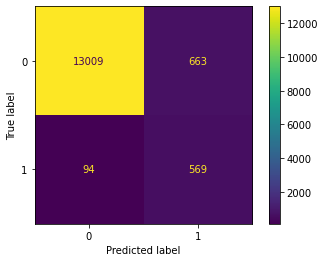

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

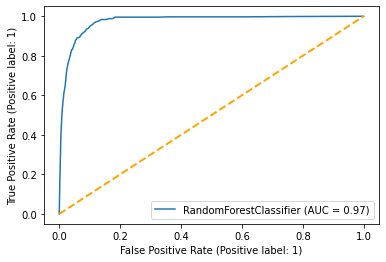

In [43]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #2: Sliding window with undersampling in training only

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [46]:
X

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1423.0,470.0,266.0,1.0,137.0,2.0,444.0,239.0,1.0,478.0,3.0,6.0,12.0,53.0,16.0,353.0,205.0,12.0,28.0,13.0,9.0,373.0,241.0,4727.0,15000.0,2504.0,774.0,1.0,125.0,1.0,4.0,261.0,791.0
1,1423.0,471.0,266.0,1.0,137.0,2.0,445.0,239.0,1.0,478.0,3.0,13.0,38.0,17.0,3.0,188.0,40.0,23.0,92.0,9.0,3.0,276.0,91.0,4726.0,15000.0,2502.0,775.0,1.0,125.0,1.0,2.0,775.0,1449.0
2,1422.0,470.0,266.0,1.0,137.0,2.0,444.0,239.0,1.0,478.0,3.0,9.0,12.0,23.0,16.0,272.0,205.0,17.0,29.0,15.0,4.0,321.0,238.0,4725.0,15000.0,2500.0,776.0,1.0,125.0,1.0,2.0,776.0,1449.0
3,1420.0,468.0,266.0,1.0,137.0,2.0,442.0,239.0,1.0,478.0,3.0,1.0,11.0,468.0,27.0,952.0,221.0,6.0,83.0,34.0,2.0,471.0,104.0,4724.0,15000.0,2499.0,776.0,1.0,125.0,1.0,6.0,116.0,486.0
4,1420.0,468.0,266.0,1.0,137.0,2.0,442.0,239.0,1.0,478.0,3.0,9.0,12.0,23.0,16.0,272.0,205.0,18.0,30.0,11.0,8.0,311.0,231.0,4723.0,15000.0,2498.0,775.0,1.0,125.0,1.0,3.0,398.0,1052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47779,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,5.0,26.0,73.0,2.0,363.0,36.0,5.0,26.0,69.0,4.0,577.0,244.0,4054.0,15000.0,2021.0,648.0,1.0,184.0,2.0,1.0,2021.0,2033.0
47780,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,7.0,27.0,34.0,3.0,277.0,34.0,11.0,27.0,30.0,5.0,391.0,240.0,4055.0,15000.0,2022.0,649.0,1.0,184.0,2.0,1.0,2022.0,2033.0
47781,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1179.0,3.0,15.0,28.0,10.0,3.0,110.0,32.0,39.0,28.0,2.0,7.0,185.0,234.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,1.0,2023.0,2033.0
47782,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1180.0,3.0,10.0,87.0,29.0,1.0,185.0,4.0,30.0,1180.0,7.0,1.0,224.0,0.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,11.0,37.0,232.0


In [47]:
y

0        0
1        0
2        0
3        0
4        0
        ..
47779    0
47780    0
47781    0
47782    0
47783    0
Name: is_fraud, Length: 47784, dtype: int64

In [48]:
len(df) / 2

23892.0

In [49]:
8353+8350

16703

In [50]:
len(df)

47784

In [51]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 477 



In [52]:
len(df)

47784

In [53]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 477 

RangeIndex(start=0, stop=23892, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 921, 921
Counts of y = 1 and y = 0 in y_test: 229, 4550
0
Iteration difference 23892: ROC-AUC=0.9773
------------------------------------------------------------------------------------------------
RangeIndex(start=477, stop=24369, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 927, 927
Counts of y = 1 and y = 0 in y_test: 221, 4558
477
Iteration difference 23892: ROC-AUC=0.9749
------------------------------------------------------------------------------------------------
RangeIndex(start=954, stop=24846, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 930, 930
Counts of y = 1 and y = 0 in y_test: 221, 4558
954
Iteration difference 23892: ROC-AUC=0.9789
------------------------------------------------------------------------------------------------
RangeIndex(start=1431, stop=25323, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 930, 930
Counts of

13356
Iteration difference 23892: ROC-AUC=0.9744
------------------------------------------------------------------------------------------------
RangeIndex(start=13833, stop=37725, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 900, 900
Counts of y = 1 and y = 0 in y_test: 233, 4546
13833
Iteration difference 23892: ROC-AUC=0.9756
------------------------------------------------------------------------------------------------
RangeIndex(start=14310, stop=38202, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 909, 909
Counts of y = 1 and y = 0 in y_test: 224, 4555
14310
Iteration difference 23892: ROC-AUC=0.9699
------------------------------------------------------------------------------------------------
RangeIndex(start=14787, stop=38679, step=1)
Iteration 32:
Counts of y = 1 and y = 0 in y_train: 912, 912
Counts of y = 1 and y = 0 in y_test: 230, 4549
14787
Iteration difference 23892: ROC-AUC=0.9754
---------------------------------------------------------

In [54]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
47782,1098744711,1624,1878,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1180.0,3.0,10.0,87.0,29.0,1.0,185.0,4.0,30.0,1180.0,7.0,1.0,224.0,0.0,4056.0,15000.0,2023.0,649.0,1.0,184.0,2.0,11.0,37.0,232.0
47783,1098744742,1624,1878,0,H,15000,False,0.0,1535.0,452.0,337.0,1.0,147.0,2.0,393.0,259.0,1.0,1181.0,3.0,10.0,87.0,29.0,1.0,185.0,4.0,31.0,1181.0,4.0,1.0,221.0,0.0,4056.0,15000.0,2023.0,650.0,1.0,184.0,2.0,12.0,33.0,200.0


In [55]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("UCIMessages-5Perc-H15000-AUCInSlidingWindow.xlsx", index=False)

In [56]:
len(roc_auc_results)

51

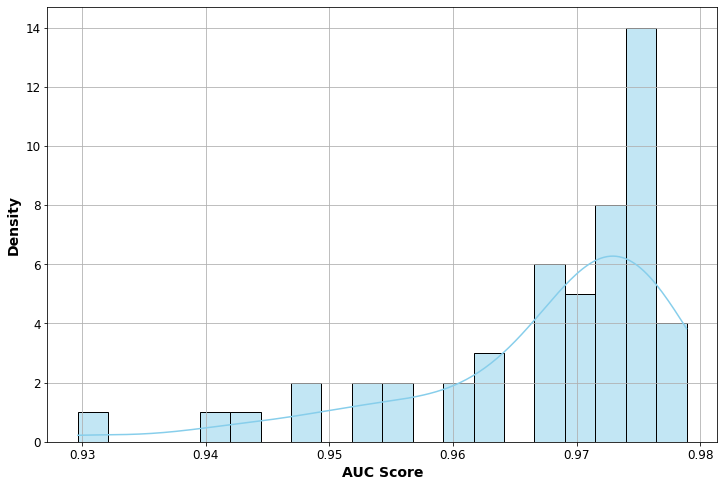

In [57]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()